In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from shutil import copyfile
sns.set(rc={'figure.figsize': (15, 8)})

In [31]:
!pip install pmdarima

In [32]:
copyfile(src = "../input/fine-dust/train_fine_dust.csv", dst = "../working/train.csv")

'../working/train.csv'

In [33]:
df_train = pd.read_csv('train.csv')
df_train

,date,PM25
0,2008-01-01,13.173913
1,2008-01-02,16.000000
2,2008-01-03,25.625000
3,2008-01-04,41.250000
4,2008-01-05,29.916667
...,...,...
4744,2020-12-27,41.625000
4745,2020-12-28,43.250000
4746,2020-12-29,46.916667
4747,2020-12-30,12.916667


In [34]:
gap =datetime.strptime('2020-12-31','%Y-%m-%d') - datetime.strptime('2008-01-01','%Y-%m-%d')
print(gap)
df_train.date.unique().shape

4748 days, 0:00:00


(4749,)

In [35]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4749 entries, 0 to 4748
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    4749 non-null   object 
 1   PM25    4749 non-null   float64
dtypes: float64(1), object(1)
memory usage: 74.3+ KB


In [36]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4749 entries, 0 to 4748
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    4749 non-null   datetime64[ns]
 1   PM25    4749 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 74.3 KB


<AxesSubplot:xlabel='date', ylabel='PM25'>

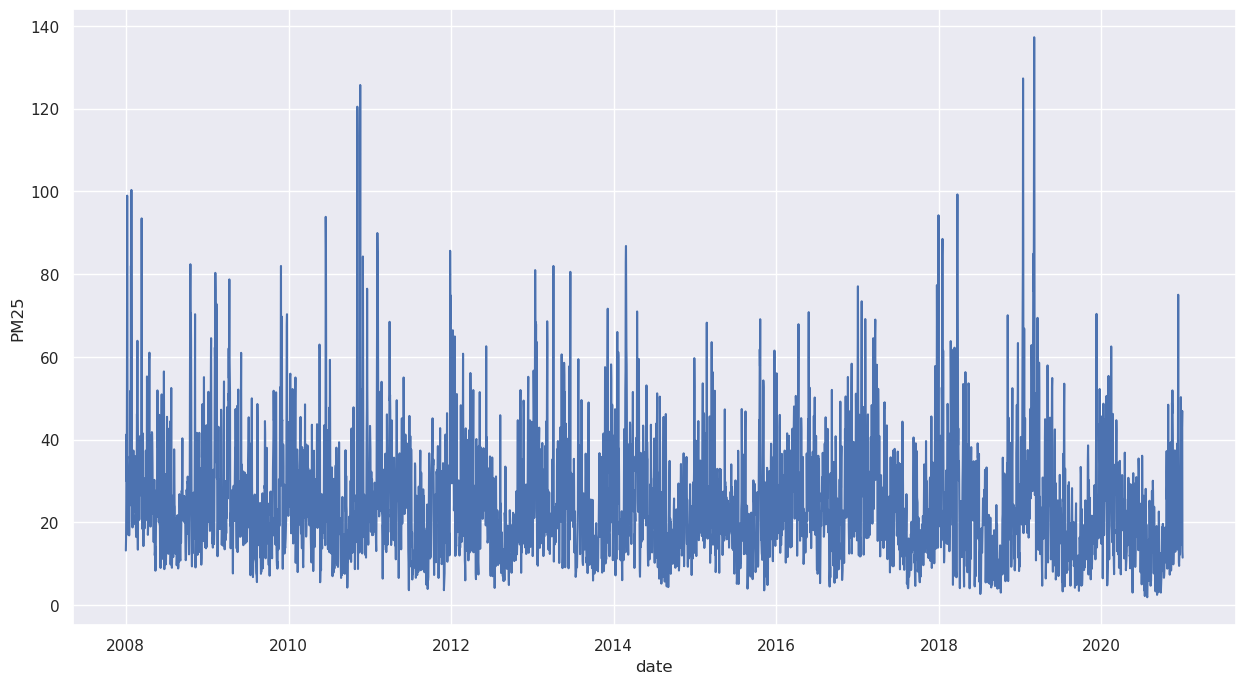

In [37]:
sns.lineplot(data=df_train, x='date', y='PM25')

<AxesSubplot:xlabel='date', ylabel='PM25'>

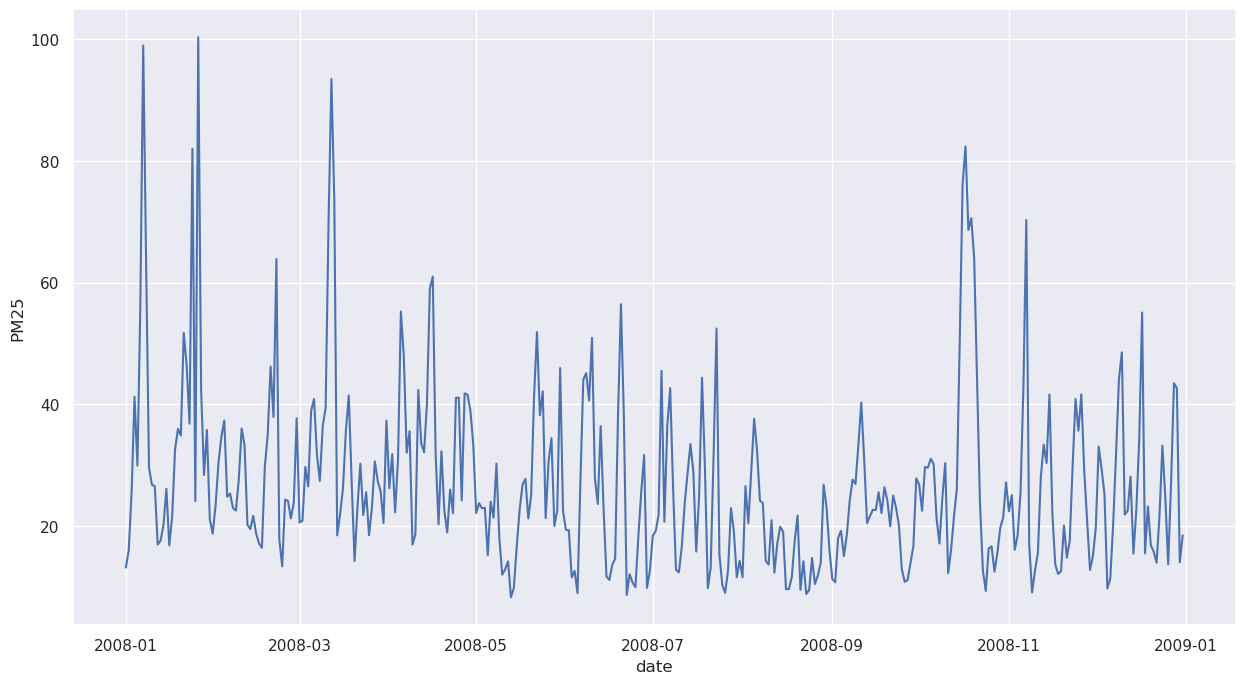

In [38]:
page1 = df_train[(df_train['date'] >= '2008-01-01') & (df_train['date'] <= '2008-12-31')]
page2 = df_train[(df_train['date'] >= '2009-01-01') & (df_train['date'] <= '2009-12-31')]
page3 = df_train[(df_train['date'] >= '2010-01-01') & (df_train['date'] <= '2010-12-31')]

sns.lineplot(data = page1, x='date', y='PM25')

# Stationary 한것 같다

In [39]:
from statsmodels.tsa.stattools import adfuller

for page in [page1, page2, page3]:
    results = adfuller(page['PM25'])
    print(results[1])

3.721197961715452e-17
1.5727462328313891e-09
0.006322664889779162


### p-value가 0.05보다 작으므로 유의수준 5% 하에서 귀무가설(정상 시계열이 아니다)을 기각

# 어 이거 시계열 아닌데...

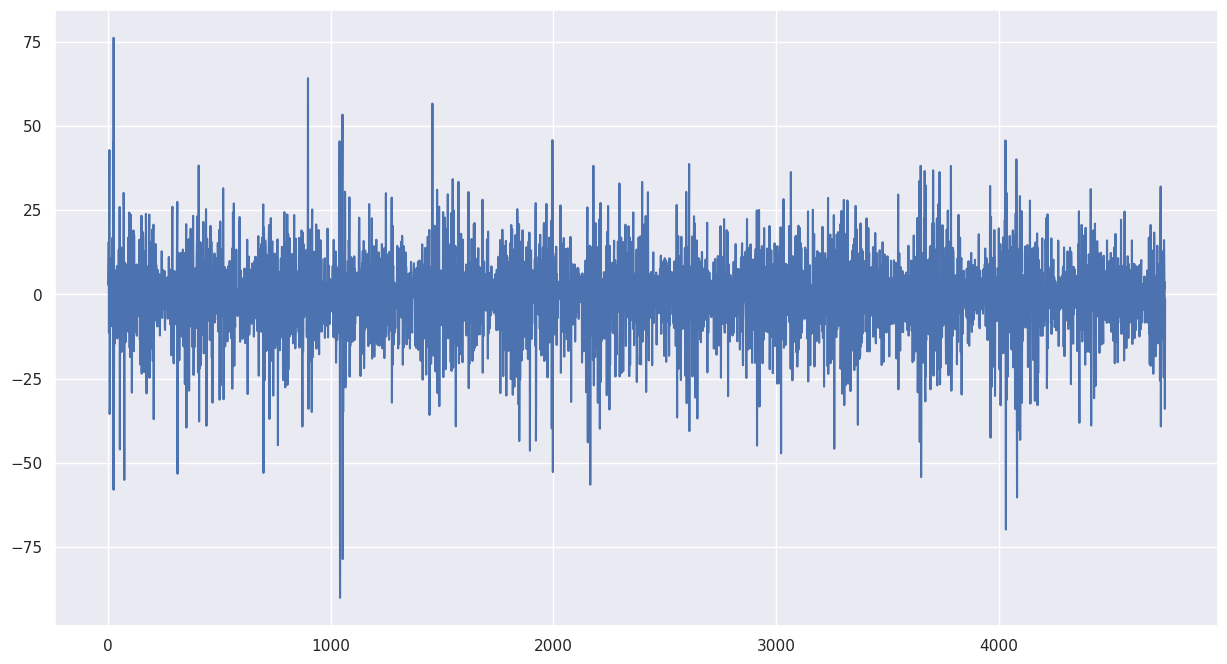

In [40]:
diff_1 = df_train['PM25'].diff().dropna()
plt.plot(diff_1)
plt.show()

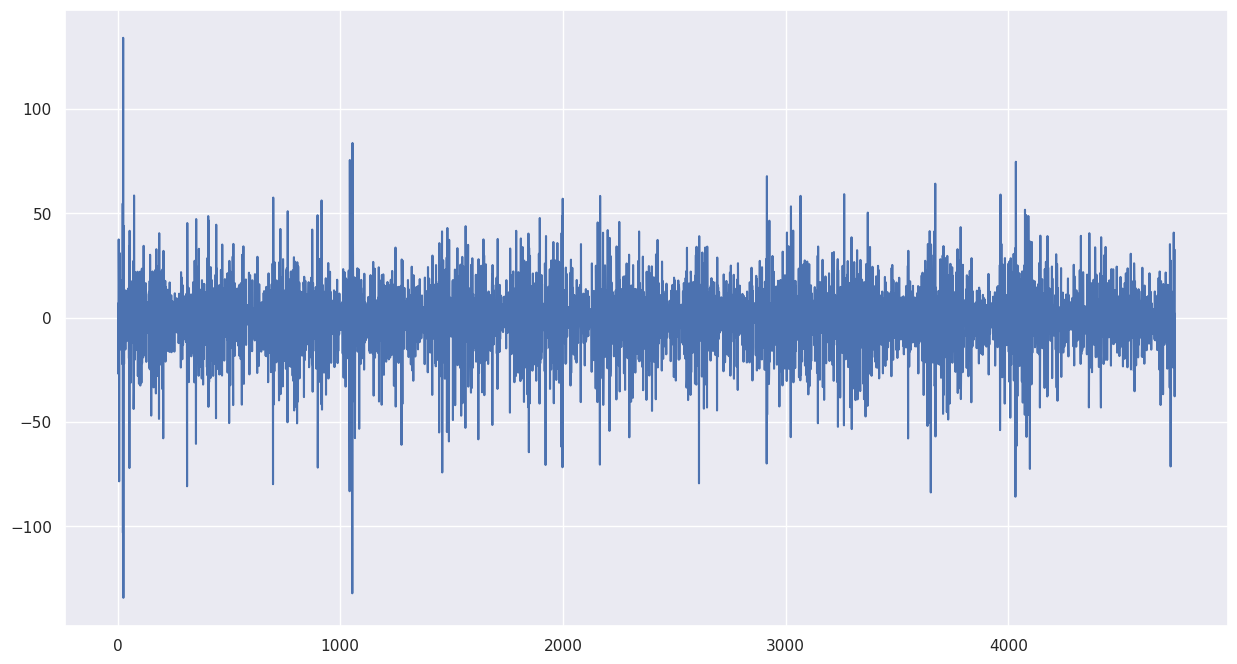

In [41]:
diff_2 = diff_1.diff().dropna()
plt.plot(diff_2)
plt.show()

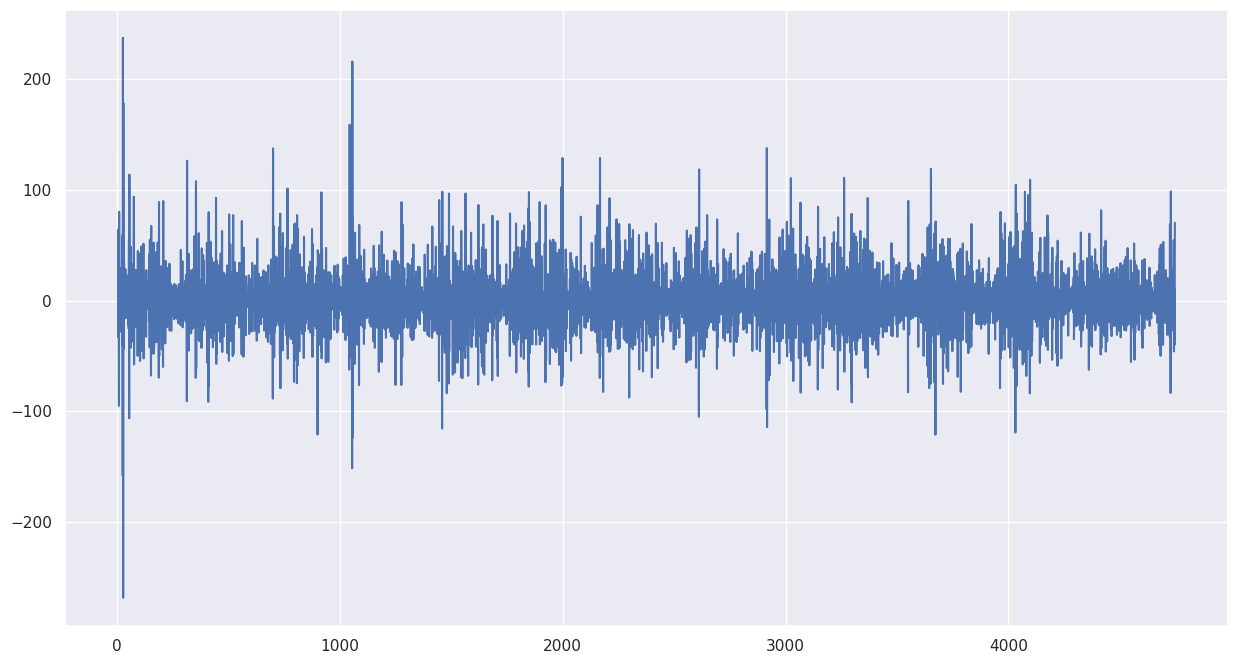

In [42]:
diff_3 = diff_2.diff().dropna()
plt.plot(diff_3)
plt.show()

# 차분 d는 3을 적용하자

In [43]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

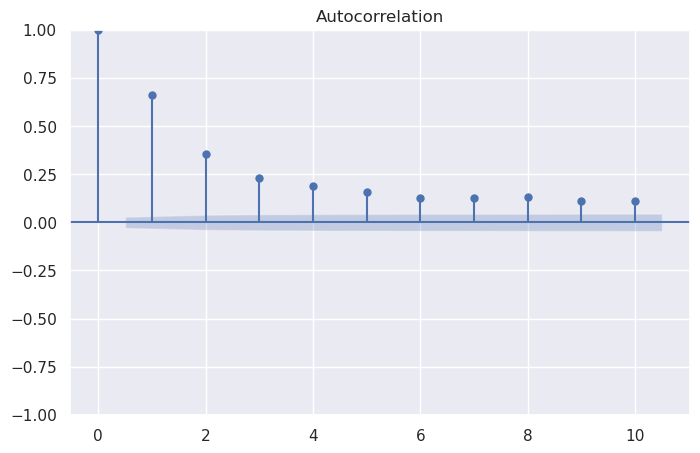

In [44]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
sm.graphics.tsa.plot_acf(df_train['PM25'], lags=10, ax=ax)
plt.show()

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


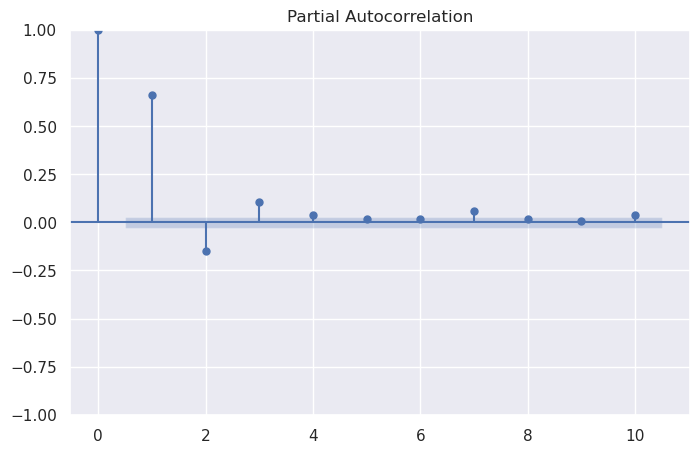

In [45]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
sm.graphics.tsa.plot_pacf(df_train['PM25'], lags=10, ax=ax)
plt.show()

# p는 2이 일것 같다

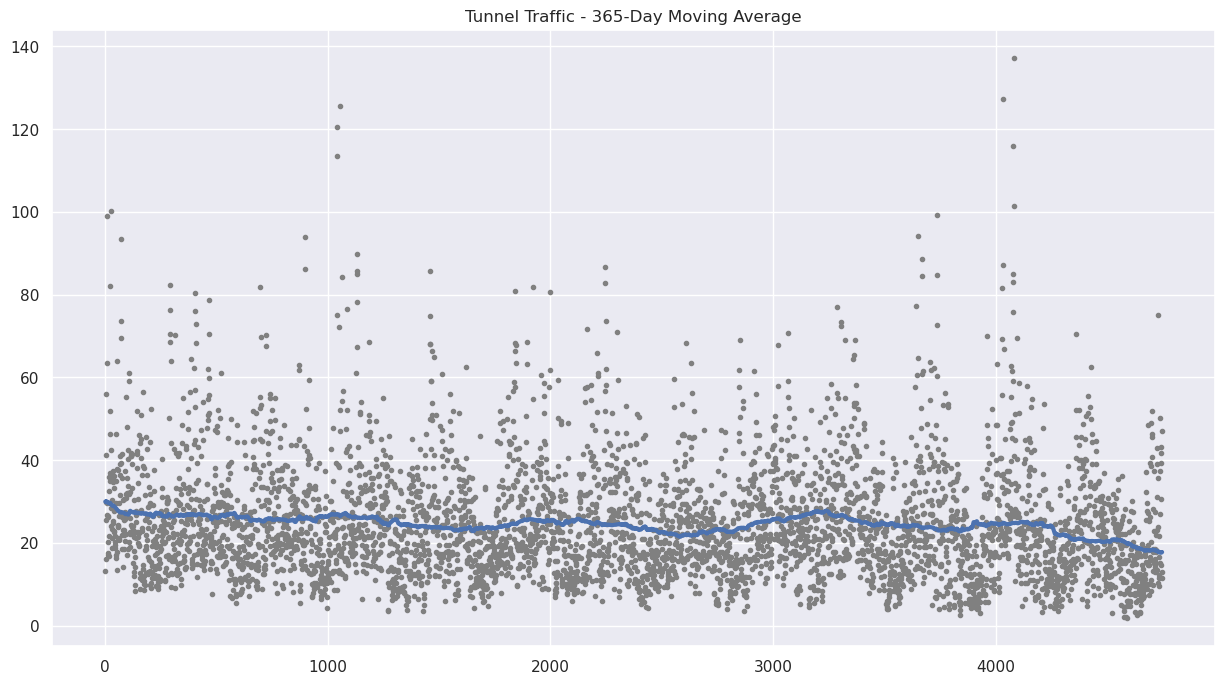

In [46]:
moving_average = df_train['PM25'].rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = df_train['PM25'].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, legend=False,
);

# q는 없는 것 같다

In [47]:
model = sm.tsa.arima.ARIMA(df_train['PM25'], order=(2, 3, 0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   PM25   No. Observations:                 4749
Model:                 ARIMA(2, 3, 0)   Log Likelihood              -20951.178
Date:                Mon, 27 Mar 2023   AIC                          41908.357
Time:                        11:42:08   BIC                          41927.752
Sample:                             0   HQIC                         41915.173
                               - 4749                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8600      0.008   -105.398      0.000      -0.876      -0.844
ar.L2         -0.4907      0.009    -52.361      0.000      -0.509      -0.472
sigma2       399.7663      5.021     79.612      0.0

In [48]:
import pmdarima as pm
from pmdarima.arima import ndiffs

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=35597.645, Time=2.06 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=35594.859, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=35587.623, Time=1.65 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=35574.261, Time=4.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=35592.859, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=35573.395, Time=0.45 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=35574.274, Time=3.99 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=35576.230, Time=9.58 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=34732.700, Time=1.51 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=34732.906, Time=7.91 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=34732.905, Time=11.80 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=34734.903, Time=18.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=35586.809, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=34581.211, Time=1.80 sec
 AR

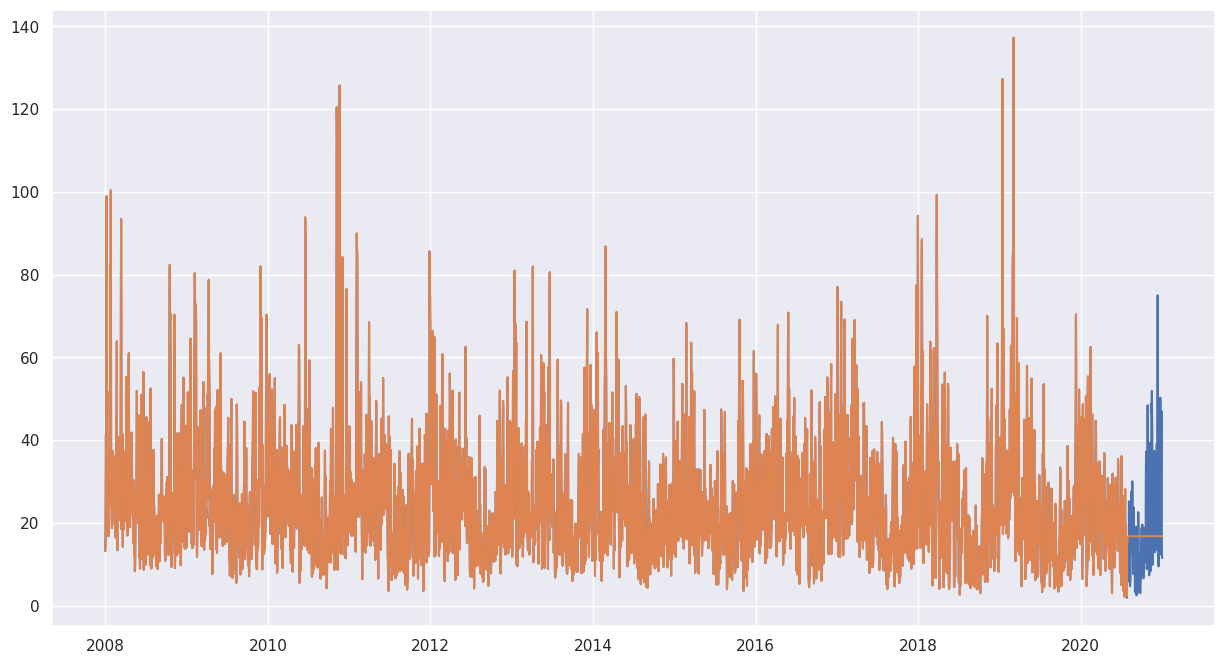

In [49]:
sub_data = df_train
train_data_part = sub_data[sub_data['date'] >= '2008-01-01']
part = train_data_part['PM25']
train = part.iloc[0:part.shape[0]-160]
test = part.iloc[part.shape[0]-160:part.shape[0]]

kpss_diffs = ndiffs(train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(kpss_diffs, adf_diffs)

model = pm.auto_arima(y=train, d=n_diffs, start_p=0, max_p=3, start_q=0, max_q=3, m=12,
                             seasonal=True, stepwise=True, trace=True)
model_fit = model.fit(train)

result = model_fit.predict(n_periods=160)
results = np.asarray(result).tolist()

plot1 = list(part)
plot2 = (list(train))
plot2.extend(results)
print('{} / {}'.format(len(plot1), len(plot2)))

x_date = train_data_part['date'].to_list()

plt.plot(x_date, plot1)
plt.plot(x_date, plot2)

/opt/conda/lib/python3.7/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2285.799, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2287.028, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2285.673, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2283.799, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.691 seconds
366 / 366


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


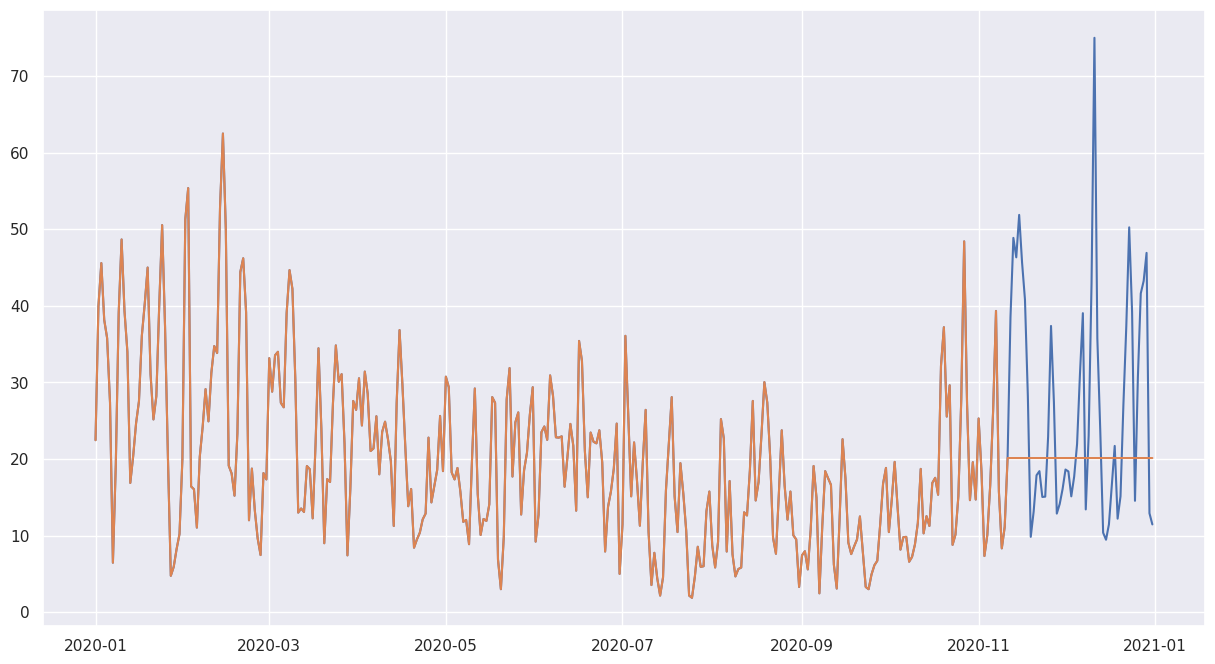

In [50]:
sub_data = df_train
train_data_part = sub_data[sub_data['date'] >= '2020-01-01']
part = train_data_part['PM25']
train = part.iloc[0:part.shape[0]-50]
test = part.iloc[part.shape[0]-50:part.shape[0]]

kpss_diffs = ndiffs(train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(kpss_diffs, adf_diffs)

model = pm.auto_arima(y=train, d=n_diffs, start_p=0, max_p=3, start_q=0, max_q=3, m=12,
                             seasonal=False, stepwise=True, trace=True)
model_fit = model.fit(train)

result = model_fit.predict(n_periods=50)
results = np.asarray(result).tolist()

plot1 = list(part)
plot2 = (list(train))
plot2.extend(results)
print('{} / {}'.format(len(plot1), len(plot2)))

x_date = train_data_part['date'].to_list()

plt.plot(x_date, plot1)
plt.plot(x_date, plot2)

# 선형 회귀 모델 분석

In [51]:
def add_shifts(df_input, **cols):
    df = df_input.copy()
    for col, n_shift in cols.items():
        for i in range (1, n_shift+1):
            df[col+'-'+str(i)]=df[col].shift(i)
    return df

def add_y_values(df_input, y, *future):
    df = df_input.copy()
    for i in future:
        df[y+'+'+str(i)]=df[y].shift(-i)
    return df

def get_table_multi_shifts(df, y, *future, **cols):
    df1 = add_shifts(df, **cols)
    df2 = add_y_values(df1, y, *future)
    return df2

In [52]:
df = df_train.copy()

cols = {'PM25':4}
future = [1]
df_sh = get_table_multi_shifts(df, 'PM25', *future, **cols)
print(df_sh.shape)
df = df_sh.dropna()
print(df.shape)

(4749, 7)
(4744, 7)


In [53]:
df

,date,PM25,PM25-1,PM25-2,PM25-3,PM25-4,PM25+1
4,2008-01-05,29.916667,41.250000,25.625000,16.000000,13.173913,56.083333
5,2008-01-06,56.083333,29.916667,41.250000,25.625000,16.000000,98.958333
6,2008-01-07,98.958333,56.083333,29.916667,41.250000,25.625000,63.416667
7,2008-01-08,63.416667,98.958333,56.083333,29.916667,41.250000,29.583333
8,2008-01-09,29.583333,63.416667,98.958333,56.083333,29.916667,26.791667
...,...,...,...,...,...,...,...
4743,2020-12-26,30.666667,14.541667,39.208333,50.250000,37.333333,41.625000
4744,2020-12-27,41.625000,30.666667,14.541667,39.208333,50.250000,43.250000
4745,2020-12-28,43.250000,41.625000,30.666667,14.541667,39.208333,46.916667
4746,2020-12-29,46.916667,43.250000,41.625000,30.666667,14.541667,12.916667


In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error,r2_score   

In [55]:
lr= LinearRegression()
rfr = RandomForestRegressor()
lgbm_r = LGBMRegressor()

In [56]:
def model_run(model, X, y, shuffle=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                shuffle=shuffle, random_state=9)
    model.fit(X_train, y_train) 
    return model.score(X_test, y_test).round(4)

In [57]:
model = lr
result = []
for window_size in range(1,100,2):
    df = df_train.copy()
    cols = {'PM25': window_size}    # 윈도우 사이즈를 변경해 가며
    future = [1]
    df_sh = get_table_multi_shifts(df, 'PM25', *future, **cols)
    df_sh = df_sh.dropna()
    X = df_sh[df_sh.columns.difference(['PM25+1', 'date'])]
    #y = df_sh['PM25+1'].values
    y = df_sh['PM25+1'].values
    score = model_run(model, X, y, shuffle=False)
    result.append((window_size, score))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """


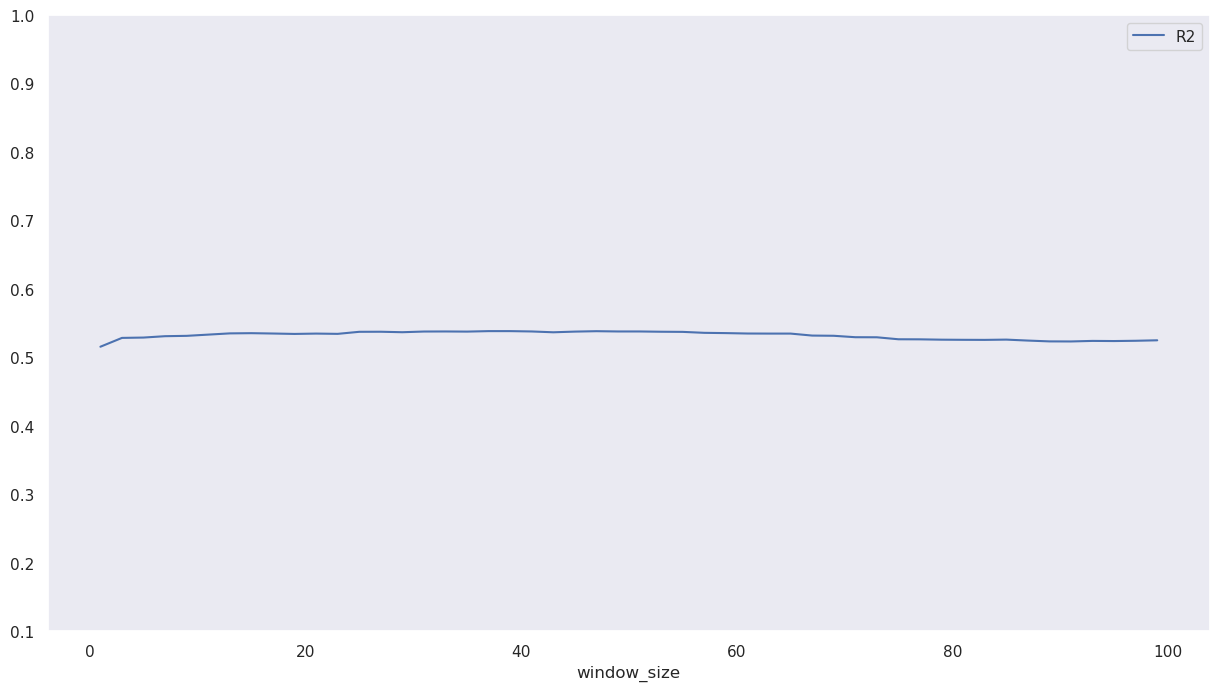

In [58]:
df_result = pd.DataFrame(result, columns=['window_size','R2'])
df_result.set_index('window_size', drop=True).plot(ylim=[0.1,1])
plt.grid(axis = 'both')

In [59]:
df_result['window_size'][df_result["R2"].idxmax()], df_result["R2"].max()

(37, 0.5382)

# End of script